In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nussl
from utils import viz, data
import yaml

In [41]:
from models.MaskInference import MaskInference
nussl.ml.register_module(MaskInference)

In [42]:
fit_models = ['ST_mask_0.01LR_5layer','test_auto']
inspect_model = 0

In [43]:
model_path = 'models/'+fit_models[inspect_model]+'/checkpoints/latest.model.pth'
optimizer_path = 'models/'+fit_models[inspect_model]+'/checkpoints/latest.optimizer.pth'
config_path = 'models/'+fit_models[inspect_model]+'/configs.yml'

In [44]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()
stft_params = nussl.STFTParams(**configs['stft_params'])

In [45]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [46]:
model_checkpoint['metadata'].keys()

dict_keys(['config', 'nussl_version', 'stft_params', 'sample_rate', 'num_channels', 'train_dataset', 'trainer.state_dict', 'trainer.state.epoch_history'])

In [47]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 25,
 'epoch_length': 25,
 'max_epochs': 25,
 'output': {'loss_L1': 0.00028112094150856137, 'loss': 0.00028112094150856137},
 'metrics': {'avg_loss': 0.0005012928129155552},
 'seed': None}

In [48]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

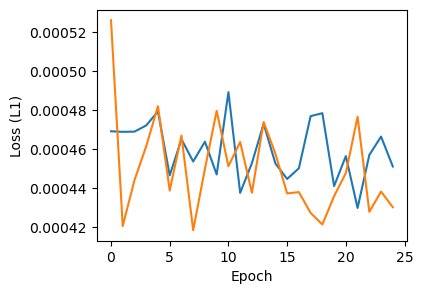

In [49]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

In [50]:
#Load in the model
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path=model_path,
    device='cpu',
)


#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['test_folder'], num_mixtures=999999, coherent_prob=1.0, duration=5)
item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


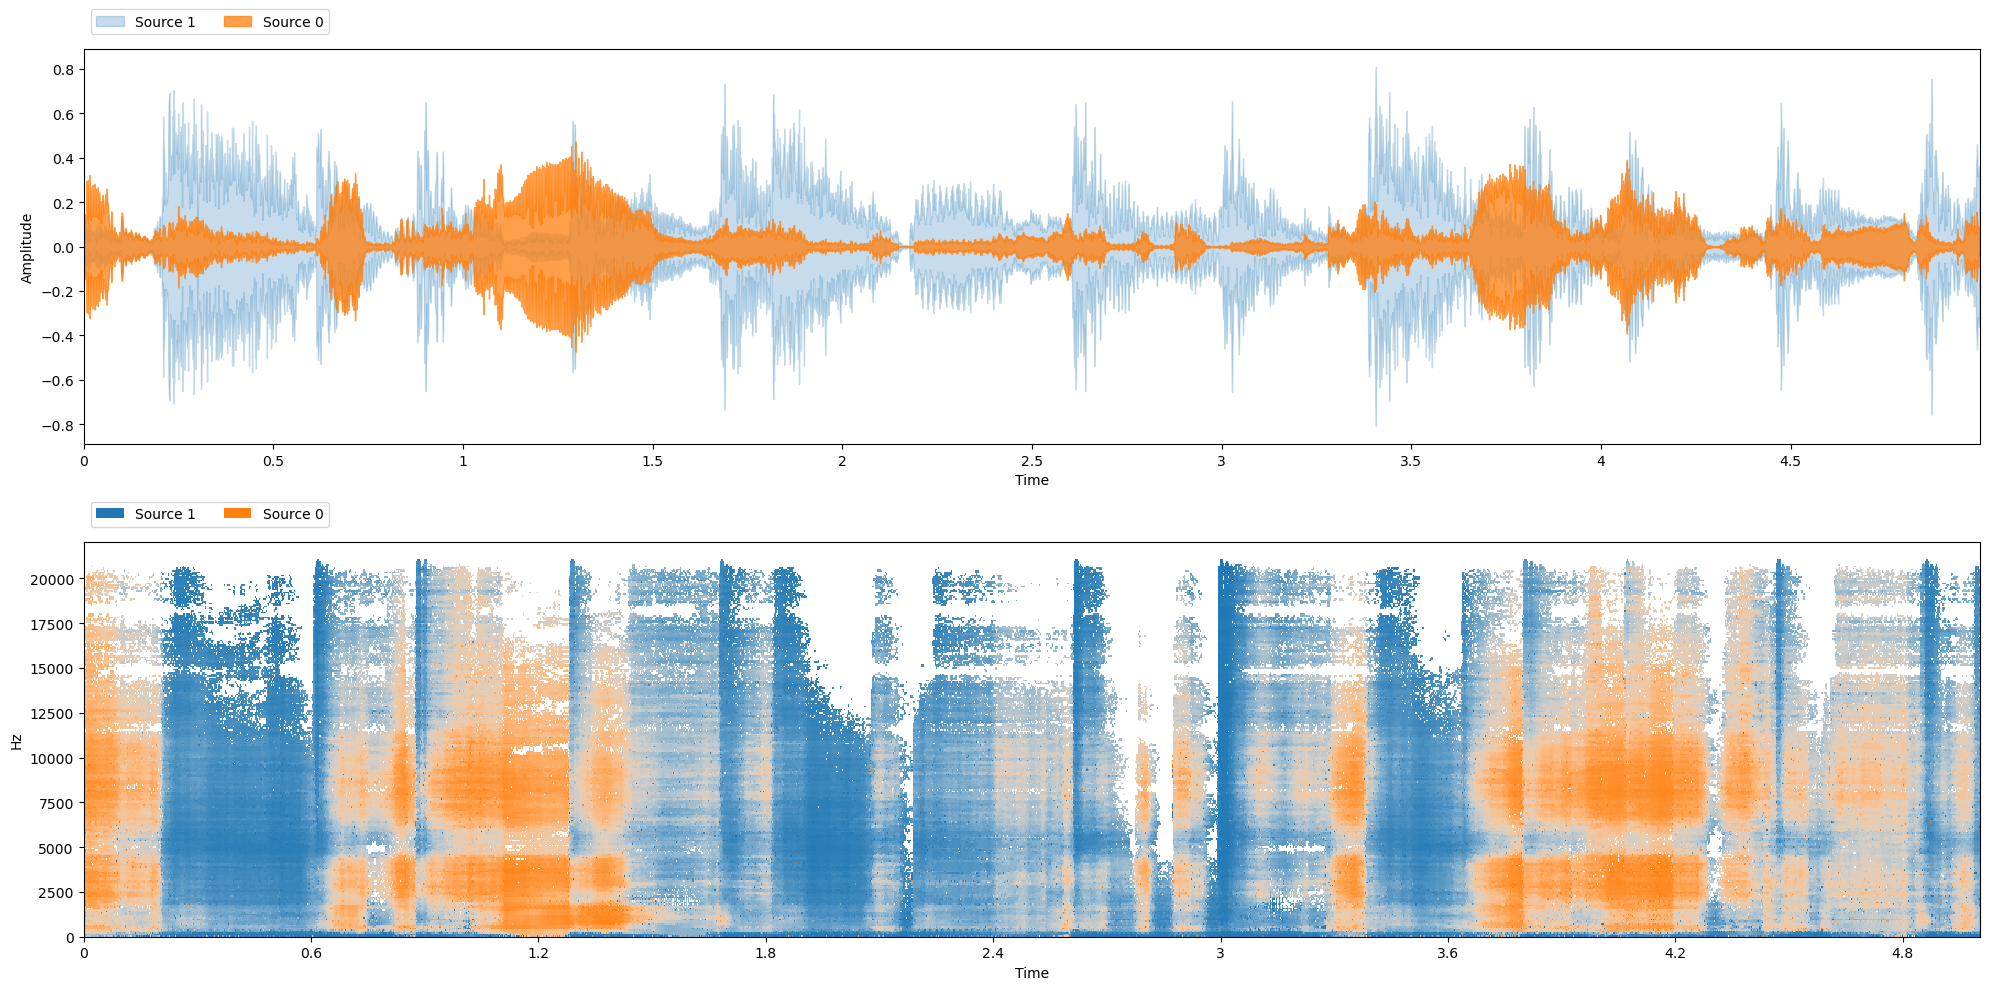


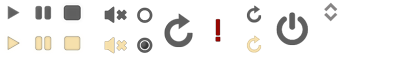
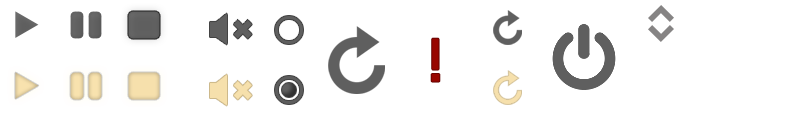
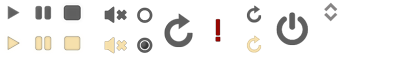

In [29]:
viz.show_sources(estimates)

In [14]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)

# Just do 5 items for speed. Change to 50 for actual experiment.
for i in range(5):
    item = test_dataset[i]
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()

In [52]:
scores

{'combination': [0, 1],
 'permutation': [0, 1],
 'vocals': {'SI-SDR': [-1.5929489167165722, -1.385198039846511],
  'SI-SIR': [4.9134601319975575, 3.1989126411968956],
  'SI-SAR': [-0.4941287127633687, 0.47237771240412607],
  'SD-SDR': [-6.371650949447218, -3.6979925728559455],
  'SNR': [2.2590875996168767, 2.2510649313709634],
  'SRR': [-4.614478263812588, 0.14367898334814386],
  'SI-SDRi': [4.7263693884368365, 4.287239006001748],
  'SD-SDRi': [-0.052320002208401384, 1.9748628068889285],
  'SNRi': [8.547796658376235, 8.089285296075793],
  'MIX-SI-SDR': [-6.319318305153408, -5.672437045848259],
  'MIX-SD-SDR': [-6.319330947238817, -5.672855379744874],
  'MIX-SNR': [-6.288709058759359, -5.83822036470483]},
 'bass+drums+other': {'SI-SDR': [7.884061904847467, 7.325880396020942],
  'SI-SIR': [9.37932660917946, 10.212334731115318],
  'SI-SAR': [13.240927043151238, 10.463661546299496],
  'SD-SDR': [7.5290591203454795, 6.344384013663811],
  'SNR': [8.49594265198417, 8.047692994374925],
  'SRR'